## Búsqueda de grid  con validación cruzada

Si bien el método de dividir los datos en conjuntos de entrenamiento, de validación y de pruebas  es viable y que  se usa con relativa frecuencia, es bastante sensible a la forma en que se dividen los datos. De la salida del fragmento de código anterior podemos ver que `GridSearchCV` selecciona `'C': 10, 'gamma': 0.001` como los mejores parámetros, mientras que la salida del código en anteriores cuadernos selecciona `'C': 100, 'gamma' : 0.001` como los mejores parámetros. Para una mejor estimación del rendimiento de generalización, en lugar de utilizar una única división en un conjunto de entrenamiento y validación, podemos usar la validación cruzada para evaluar el rendimiento de cada combinación de parámetros. Este método se puede codificar de la siguiente manera:

In [14]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.datasets import load_iris
iris = load_iris()

# dividimos los datos en conjuntos de entrenamiento+validacion y prueba
X_entrenamiento_validacion, X_prueba, y_entrenamiento_validacion, y_prueba = train_test_split(iris.data, iris.target, random_state=0)
    
# dividimos el conjunto entrenamiento+validacion en conjuntos de prueba y validacion
X_entrenamiento, X_validacion, y_entrenamiento, y_validacion = train_test_split(X_entrenamiento_validacion, y_entrenamiento_validacion, random_state=1)

mejor_puntuacion = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # para cada combinacion de parametros,
        # entrenando un SVC
        svm = SVC(gamma=gamma, C=C)
        # realizamos una validacion cruzada 
        puntuacion = cross_val_score(svm, X_entrenamiento_validacion, y_entrenamiento_validacion, cv=5)
        # calcula la precision media de la validacion cruzada 
        puntuacion = np.mean(puntuacion)
        # si tenemos una mejor puntuación, almacenamos la puntuación y los parámetros
        if puntuacion > mejor_puntuacion:
            mejor_puntuacion = puntuacion
            mejor_parametros = {'C': C, 'gamma': gamma}
            
# reconstruimos un modelo en el conjunto combinado de entrenamiento y validacion
svm = SVC(**mejor_parametros)
svm.fit(X_entrenamiento_validacion, y_entrenamiento_validacion)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Para evaluar la precisión de la SVM utilizando una configuración particular de C y gamma utilizando una validación cruzada de cinco grupos, tenemos que entrenar `36 * 5` = 180 modelos. Como se puede imaginar, la principal desventaja del uso de la validación cruzada es el tiempo que lleva entrenar a todos estos modelos.

El siguiente gráfico ilustra cómo se selecciona la mejor configuración de parámetros en el código anterior:

In [33]:
def dibuja_evaluacion_validacion_cruzada():
    iris = load_iris()
    X_entrenamiento_validacion, X_prueba, y_entrenamiento_validacion, y_prueba = train_test_split(iris.data, iris.target, random_state=0)
    parametro_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
    
    busqueda_grid = GridSearchCV(SVC(), parametro_grid, cv=5)
    busqueda_grid.fit(X_entrenamiento_validacion, y_entrenamiento_validacion)
    resultados = pd.DataFrame(busqueda_grid.cv_results_)[15:]

    mejor_valor = np.argmax(resultados.mean_test_score.values)
    plt.figure(figsize=(10, 3))
    plt.xlim(-1, len(resultados))
    plt.ylim(0, 1.1)
    for i, (_, fila) in enumerate(resultados.iterrows()):
        puntuaciones = fila[['split%d_test_score' % i for i in range(5)]]
        marcador_cv, = plt.plot([i] * 5, puntuaciones, '^', c='gray', markersize=5,
                              alpha=.5)
        marcador_medio, = plt.plot(i, fila.mean_test_score, 'v', c='none', alpha=1,
                                markersize=10, markeredgecolor='k')
        if i == mejor_valor:
            mejor_marcador, = plt.plot(i, fila.mean_test_score, 'o', c='red',
                                    fillstyle="none", alpha=1, markersize=20,
                                    markeredgewidth=3)

    plt.xticks(range(len(resultados)), [str(x).strip("{}").replace("'", "") for x
                                     in busqueda_grid.cv_results_['params']],
               rotation=90)
    plt.ylabel("Precision de validacion")
    plt.xlabel("Configuracion de parametros")
    plt.legend([marcador_cv, marcador_medio, mejor_marcador],
               ["Precision cv", "precision media", "Mejor configuracion de parametros"],
    loc=(1.05, .4))

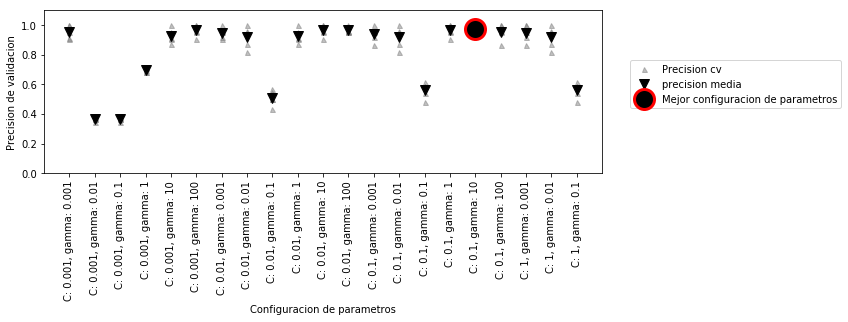

In [34]:
dibuja_evaluacion_validacion_cruzada()

Para cada configuración de parámetros (solo se muestra un subconjunto), se calculan cinco valores de precisión, uno para cada división en la validación cruzada. Luego, la precisión de validación media se calcula para cada configuración de parámetro. Se eligen los parámetros con la precisión de validación media más alta, marcados con el círculo.

El proceso general de dividir los datos, ejecutar la búsqueda grids y evaluar los parámetros finales se ilustra en la siguiente figura:

In [74]:
def dibuja_proceso_busqueda_grid():
    plt.figure(figsize=(10, 3), dpi=70)
    axes = plt.gca()
    axes.yaxis.set_visible(False)
    axes.xaxis.set_visible(False)
    axes.set_frame_on(False)

    def dibujo(ax, texto, inicio, objetivo=None):
        if objetivo is not None:
            patchB = objetivo.get_bbox_patch()
            final = objetivo.get_position()
        else:
            final = inicio
            patchB = None
        anotaciones = ax.annotate(texto, final, inicio, xycoords='axes pixels',
                                 textcoords='axes pixels', size=20,
                                 arrowprops=dict(
                                     arrowstyle="-|>", fc="w", ec="k",
                                     patchB=patchB,
                                     connectionstyle="arc3,rad=0.0"),
                                 bbox=dict(boxstyle="round", fc="w"),
                                 horizontalalignment="center",
                                 verticalalignment="center")
        plt.draw()
        return anotaciones

    paso = 100
    valor = 400

    evaluacion_final = dibujo(axes, "evaluacion final", (5 * paso, valor - 3 *
                                                       paso))
    modelo_reentrenado = dibujo(axes, "modelo reentrenado", (3 * paso, valor - 3 * paso),
                           evaluacion_final)
    mejores_parametros = dibujo(axes, "mejores parametros", (.5 * paso, valor - 3 *
                                                     paso), modelo_reentrenado)
    validacion_cruzada = dibujo(axes, "validacion cruzada", (.5 * paso, valor - 2 *
                                                       paso), mejores_parametros)
    dibujo(axes, "parametros  grid", (0.0, valor - 0), validacion_cruzada)
    datos_entrenamiento = dibujo(axes, "datos de entrenamiento", (2 * paso, valor - paso),
                         validacion_cruzada)
    dibujo(axes, "datos de entrenamiento", (2 * paso, valor - paso), modelo_reentrenado)
    datos_prueba = dibujo(axes, "datos de prueba", (5 * paso, valor - paso),
                     evaluacion_final)
    dibujo(axes, "conjunto de datos", (3.5 * paso, valor - 0.0), datos_entrenamiento)
    dibujo(axes, "conjunto de datos", (3.5 * paso, valor - 0.0), datos_prueba)
    plt.ylim(0, 1)
    plt.xlim(0, 1.5)

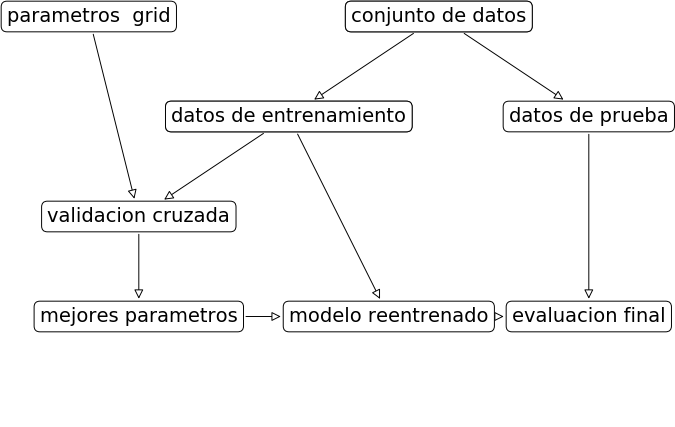

In [75]:
dibuja_proceso_busqueda_grid()

Debido a que la búsqueda grid con validación cruzada es un método muy utilizado para ajustar los parámetros, scikit-learn proporciona la clase `GridSearchCV`, que implementa en forma de estimador. Para usar la clase GridSearchCV, primero necesita especificar los parámetros que desea buscar usando un diccionario. GridSearchCV luego realizará todos los ajustes necesarios del modelo. Las claves del diccionario son los nombres de los parámetros que deseamos ajustar y los valores son los parámetros que queremos probar. Para los valores `0.001`, `0.01`, `0.1`, `1`, `10` y `100` con los paramétros C y gamma se traducen en el siguiente diccionario:

In [76]:
parametros_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                   'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("Parametros grid:\n{}".format(parametros_grid))

Parametros grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


Ahora podemos crear una instancia de la clase GridSearchCV con el modelo (SVC), el parámetro (`parametros_grid`) y la estrategia de validación cruzada que queremos usar (por ejemplo, validación cruzada estratificada con 5 grupos):

In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
busqueda_grid = GridSearchCV(SVC(), parametros_grid, cv=5)

GridSearchCV utiliza validación cruzada en lugar de la división en un conjunto de entrenamiento y validación que hemos utilizado anteriormente. Sin embargo, aún necesitamos dividir los datos en un conjunto de entrenamiento y un conjunto de prueba, para evitar sobreajustes de los parámetros:

In [80]:
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(iris.data, iris.target, random_state=0)

El objeto `busqueda_grid` que creamos se comporta como un clasificador; podemos llamar a los métodos estándar `fit`, `predict` y `score`. Un estimador scikit-learn que se crea utilizando otro estimador se denomina meta-estimador. GridSearchCV es un  meta-estimador  comúnmente utilizado. Sin embargo, cuando llamamos a `fit`, se  ejecutará validación cruzada para cada combinación de parámetros que especifiquemos en `parametros_grid`:

In [81]:
busqueda_grid.fit(X_entrenamiento, y_entrenamiento)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

El ajuste  del objeto GridSearchCV no solo busca los mejores parámetros, sino que también se adapta automáticamente a un nuevo modelo en el conjunto de datos de entrenamiento con los parámetros que produjeron el mejor rendimiento de validación cruzada.

La clase GridSearchCV proporciona una interfaz muy conveniente para acceder al modelo reentrenado utilizando los métodos de `predict` y `score`. Para evaluar qué tan bien se generalizan los mejores parámetros encontrados, podemos usar `score` en el conjunto de prueba:

In [82]:
print("Puntuacion de conjunto de prueba: {:.2f}".format(busqueda_grid.score(X_prueba, y_prueba)))

Puntuacion de conjunto de prueba: 0.97


Al elegir los parámetros mediante la validación cruzada, encontramos un modelo que alcanza el 97% de precisión en el conjunto de prueba. Lo importante aquí es que no usamos el conjunto de prueba para elegir los parámetros. Los parámetros que se encontraron se califican en el atributo `best_params_` y la mejor precisión de validación cruzada (la precisión media sobre las diferentes divisiones para esta configuración de parámetro) se almacena en `best_score_`:

In [83]:
print("Mejores parametros: {}".format(busqueda_grid.best_params_))
print("Mejor puntuacion de validacion cruzada: {:.2f}".format(busqueda_grid.best_score_))

Mejores parametros: {'C': 100, 'gamma': 0.01}
Mejor puntuacion de validacion cruzada: 0.97


De nuevo, hay que tener cuidado de no confundir `best_score_` con el rendimiento de generalización del modelo calculado mediante el método `score` en el conjunto de prueba. El uso del método `score`  (o  evaluando  la salida del método de `predict`) emplea un modelo entrenado en todo el conjunto de entrenamiento. El atributo `best_score_` almacena la precisión media de validación cruzada, con la validación cruzada realizada en el conjunto de entrenamiento.

A veces es útil tener acceso al modelo real que fue encontrado, por ejemplo, para ver los coeficientes o las características importantes. Se puede acceder al modelo con los mejores parámetros entrenados en todo el conjunto de entrenamiento utilizando el atributo `best_estimator_`:

In [84]:
print("Mejor estimador:\n{}".format(busqueda_grid.best_estimator_))

Mejor estimador:
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Debido a que `busqueda_grid` tiene métodos `predict` y `score`, no se necesita usar best_estimator_ para hacer predicciones o evaluar el modelo.

### Analizando los resultado de  validación cruzada

A menudo es útil visualizar los resultados de la validación cruzada, para comprender cómo la generalización del modelo depende de los parámetros que estamos buscando. Como la búsqueda grid son bastante costosas de ejecutar, a menudo es una buena idea comenzar con grid relativamente pequeño y ordinario. Luego podemos inspeccionar los resultados de la búsqueda cruzada con validación cruzada y posiblemente ampliar nuestra búsqueda.

Los resultados de una búsqueda grid se pueden encontrar en el atributo `cv_results_`, que es un diccionario que almacena todos los aspectos de la búsqueda. Contiene una gran cantidad de detalles, como  se puede ver en la siguiente salida y se ve mejor después de convertirlo en un DataFrame de pandas:

In [85]:
# convertimos a un DataFrame
resultados = pd.DataFrame(busqueda_grid.cv_results_)
# mostramos las primeras 5 filas
display(resultados.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.026007,0.049296,0.002985,0.005143,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
1,0.000817,0.000093,0.000299,0.000042,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
2,0.000846,0.000113,0.000341,0.000110,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
3,0.000806,0.000028,0.000289,0.000007,0.001,1,"{'C': 0.001, 'gamma': 1}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852
4,0.000831,0.000083,0.000303,0.000041,0.001,10,"{'C': 0.001, 'gamma': 10}",0.375,0.347826,0.363636,...,0.366071,0.011371,22,0.363636,0.370787,0.366667,0.366667,0.362637,0.366079,0.002852


Cada fila de `resultados` corresponde a una configuración de parámetro particular. Para cada configuración, se registran los resultados de todas las divisiones de validación cruzada, así como la media y la desviación estándar de todas las divisiones. Como buscábamos una grid bidimensional de parámetros (C y gamma), esto se visualiza mejor como un mapa de calor. Primero extraemos los puntajes de validación promedio, luego rediseñamos los puntajes para que los ejes correspondan a C y gamma. 

In [91]:
def mapa_calor(valores, xetiqueta, yetiqueta, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # dibuja los puntajes mediosde validación cruzada
    img = ax.pcolor(valores, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xetiqueta)
    ax.set_ylabel(yetiqueta)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, valor in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % valor, color=c, ha="center", va="center")
    return img

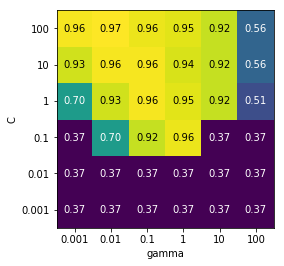

In [94]:
puntuaciones = np.array(resultados.mean_test_score).reshape(6, 6)
# dibuja los puntajes mediosde validación cruzada
mapa_calor(puntuaciones, xetiqueta='gamma', xticklabels=parametros_grid['gamma'],
           yetiqueta='C', yticklabels=parametros_grid['C'], cmap="viridis")

Cada punto en el mapa de calor corresponde a una ejecución de validación cruzada, con una configuración de parámetro particular. El color codifica la precisión de validación cruzada, con colores claros que significan alta precisión y colores oscuros que significan baja precisión. Se puede ver que SVC es muy sensible a la configuración de los parámetros. Para muchas de las configuraciones de parámetros, la precisión es de alrededor del 40%, lo cual es bastante malo; para otros ajustes, la precisión es de alrededor del 96%. 

Podemos quitarle a este gráfico varias cosas. Primero, los parámetros que ajustamos son muy importantes para obtener un buen rendimiento. Ambos parámetros (C y gamma) importan mucho, ya que ajustarlos puede cambiar la precisión del 40% al 96%. Además, los rangos que elegimos para los parámetros son rangos en los cuales vemos cambios significativos en el resultado. También es importante tener en cuenta que los rangos para los parámetros son lo suficientemente grandes: los valores óptimos para cada parámetro no están en los bordes de la gráfica.

Ahora veamos algunos gráficos donde el resultado es menos ideal, porque los rangos de búsqueda no se eligieron correctamente.

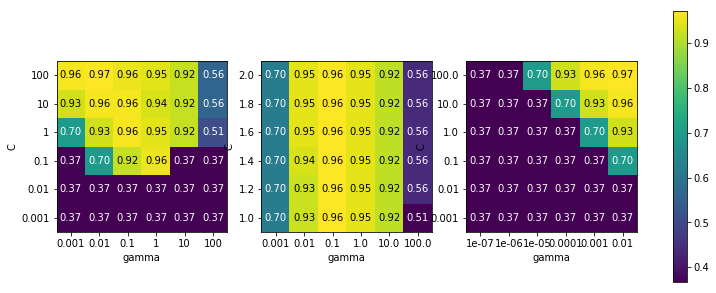

In [96]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))

parametros_grid_lineal = {'C': np.linspace(1, 2, 6),
                     'gamma':  np.linspace(1, 2, 6)}

parametros_grid_log = {'C': np.linspace(1, 2, 6),
                      'gamma':  np.logspace(-3, 2, 6)}

parametros_grid_rango = {'C': np.logspace(-3, 2, 6),
                    'gamma':  np.logspace(-7, -2, 6)}

for parametros_grid, ax in zip([parametros_grid, parametros_grid_log,
                           parametros_grid_rango], axes):
    busqueda_grid = GridSearchCV(SVC(), parametros_grid, cv=5)
    busqueda_grid.fit(X_entrenamiento, y_entrenamiento)
    puntuaciones = busqueda_grid.cv_results_['mean_test_score'].reshape(6, 6)

    # dibujamos las puntuaciones de validacion cruzada media 
    imagen_puntuaciones = mapa_calor(
        puntuaciones, xetiqueta='gamma', yetiqueta='C', xticklabels=parametros_grid['gamma'],
        yticklabels=parametros_grid['C'], cmap="viridis", ax=ax)

plt.colorbar(imagen_puntuaciones, ax=axes.tolist())

El primer panel no muestra ningún cambio, con un color constante en toda la cuadrícula de parámetros. En este caso, esto se debe a una escala inadecuada y al rango de los parámetros C y gamma. Sin embargo, si no se ve ningún cambio en la precisión sobre las diferentes configuraciones de parámetros, también podría ser que un parámetro simplemente no sea importante. Por lo general, es bueno intentar valores muy extremos primero, para ver si hay algún cambio en la precisión como resultado de cambiar un parámetro.

El segundo panel muestra un patrón de franja vertical. Esto indica que solo la configuración del parámetro gamma hace la diferencia. Esto podría significar que el parámetro gamma está buscando valores interesantes, pero el parámetro C no lo está, o podría significar que el parámetro C no es importante.

El tercer panel muestra cambios tanto en C como en gamma. Sin embargo, podemos ver que en toda la parte inferior izquierda del gráfico, nada interesante está sucediendo. Probablemente podamos excluir los valores muy pequeños de futuras búsquedas en el grid. La configuración óptima de los parámetros está en la parte superior derecha. Como el punto óptimo está en el borde del gráfico, podemos esperar que haya aún mejores valores más allá de este límite, y es posible que deseemos cambiar nuestro rango de búsqueda para incluir más parámetros en esta región.

Ajustar la cuadrícula de parámetros en función de los puntajes de validación cruzada está perfectamente bien, y es una buena forma de explorar la importancia de los diferentes parámetros. Sin embargo, no debe probar diferentes rangos de parámetros en el conjunto de prueba final; la evaluación del conjunto de prueba debe ocurrir solo una vez cuando sepamos exactamente qué modelo queremos usar.


### Búsqueda en espacios que no son grids

En algunos casos, probar todas las combinaciones posibles de todos los parámetros como lo hace generalmente GridSearchCV, no es una buena idea. Por ejemplo, SVC tiene un parámetro kernel, y dependiendo de qué kernel se elija, otros parámetros serán relevantes. Si `kernel = 'linear'`, el modelo es lineal, y solo se usa el parámetro C. Si tenemos  `kernel = 'rbf'`, se usan los parámetros C y gamma (pero no otros parámetros como `degree`).

En este caso, buscar todas las combinaciones posibles de C, gamma y kernel no tendría sentido: si `kernel = 'linear'`, gamma no se usa, y probar valores diferentes para gamma sería una pérdida de tiempo. Para tratar este tipo de parámetros "condicionales", GridSearchCV permite que `parametros_grid` sea una lista de diccionarios. Cada diccionario en la lista se expande en un grid  independiente. Una posible búsqueda de grid que involucre kernel y parámetros podría verse así:

In [97]:
parametros_grid = [{'kernel': ['rbf'],
                    'C': [0.001, 0.01, 0.1, 1, 10, 100],
                    'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
                   {'kernel': ['linear'],'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
print("Lista de grids:\n{}".format(parametros_grid))

Lista de grids:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


En el primer grid, el parámetro kernel está  configurado a 'rbf' (no es que la entrada para kernel sea una lista de longitud uno), y tanto los parámetros C como gamma son variados. En el segundo grid, el parámetro kernel siempre se establece en lineal, y solo se varía C.

In [98]:
busqueda_grid = GridSearchCV(SVC(), parametros_grid, cv=5)
busqueda_grid.fit(X_entrenamiento, y_entrenamiento)
print("Mejores parametros: {}".format(busqueda_grid.best_params_))
print("Mejor puntuacion de la validacion cruzada: {:.2f}".format(busqueda_grid.best_score_))

Mejores parametros: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Mejor puntuacion de la validacion cruzada: 0.97


Veamos los `cv_results_` nuevamente. Como era de esperar, si kernel es "lineal", solo se varía C:

In [99]:
resultados = pd.DataFrame(busqueda_grid.cv_results_)
display(resultados.T)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.00121603,0.000978518,0.000952244,0.00117192,0.00107975,0.001267,0.000836802,0.000860596,0.000898027,0.00104527,...,0.00043993,0.000610828,0.00105247,0.00118537,0.000527477,0.000471687,0.000461245,0.000397205,0.000414801,0.000407362
std_fit_time,0.00023202,0.000127197,2.66641e-05,0.000240476,0.000205934,0.000557988,4.39295e-05,0.000191886,0.000102184,0.000274985,...,2.15657e-05,5.22453e-05,5.04888e-05,9.20957e-05,2.36396e-05,1.28857e-05,8.98742e-05,1.63138e-05,1.73607e-05,7.40128e-05
mean_score_time,0.00042448,0.000389147,0.000474834,0.000483227,0.000376081,0.000511408,0.000310421,0.000347281,0.00031991,0.000355911,...,0.000232983,0.000260878,0.000281382,0.000321341,0.000247955,0.000272322,0.000248718,0.000236225,0.000232935,0.000220823
std_score_time,3.02713e-05,4.36319e-05,0.000160717,0.000118113,4.27366e-05,0.000182256,2.53814e-05,0.00010351,1.98386e-05,9.91199e-05,...,4.38949e-06,2.09339e-05,4.61917e-06,2.49834e-05,6.70122e-06,3.8861e-05,3.69275e-05,2.12154e-05,3.07532e-05,2.34124e-05
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,...,0.958333,0.916667,0.875,0.541667,0.375,0.916667,0.958333,1,0.958333,0.958333
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,1,1,0.956522,0.478261,0.347826,0.826087,0.913043,0.956522,1,1


### Usando diferentes estrategias de validación cruzada con  búsqueda grids

De forma similar a `cross_val_score`, `GridSearchCV` utiliza la validación cruzada estratificada por defecto para la clasificación, y la validación cruzada para la regresión. Sin embargo, también puede pasar cualquier divisor de validación cruzada, como el parámetro cv en GridSearchCV. En particular, para obtener solo una división en un conjunto de entrenamiento y validación, se puede usar `ShuffleSplit` o `StratifiedShuffleSplit` con `n_iter = 1`. Esto podría ser útil para conjuntos de datos muy grandes o modelos muy lentos.

### validación cruzada anidada

En los ejemplos anteriores, pasamos de utilizar una única división de los datos en entrenamiento, validación y pruebas para dividir los datos en conjuntos de entrenamiento y prueba y luego realizar la validación cruzada en el conjunto de entrenamiento. Pero al usar GridSearchCV como se describió anteriormente, todavía tenemos una única división de los datos en los conjuntos de entrenamiento y prueba, lo que puede hacer que nuestros resultados sean inestables y hacer que dependamos demasiado de esta única división de los datos.

Podemos ir un paso más allá, y en lugar de dividir los datos originales en los conjuntos de entrenamiento y prueba una vez, use múltiples divisiones de validación cruzada. Esto dará como resultado lo que se denomina validación cruzada anidada. En la validación cruzada anidada, hay un bucle externo sobre las divisiones de los datos en los conjuntos de entrenamiento y prueba. Para cada uno de ellos, se ejecuta una búsqueda grids (lo que puede dar lugar a diferentes parámetros para cada división en el bucle externo). Luego, para cada división externa, se informa el puntaje del conjunto de prueba utilizando los mejores ajustes.

El resultado de este procedimiento es una lista de puntuaciones, no un modelo, ni una configuración de parámetros. Los puntajes nos dicen qué tan bien se generaliza un modelo, dados los mejores parámetros encontrados por el grid. Como no proporciona un modelo que se pueda usar con datos nuevos, la validación cruzada anidada se utiliza raramente cuando se busca un modelo predictivo para aplicarlo a datos futuros. Sin embargo, puede ser útil para evaluar qué tan bien funciona un modelo dado en un conjunto de datos particular.

Implementar la validación cruzada anidada en scikit-learn es sencillo. Llamamos a `cross_val_score` con una instancia de GridSearchCV como modelo:

In [103]:
parametros_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

puntuaciones = cross_val_score(GridSearchCV(SVC(), parametros_grid, cv=5),
                               iris.data, iris.target, cv=5)
print("Puntuaciones de validacion cruzada : ", puntuaciones)
print("Puntuacion media de validacion cruzada: ", puntuaciones.mean())

Puntuaciones de validacion cruzada :  [0.96666667 1.         0.96666667 0.96666667 1.        ]
Puntuacion media de validacion cruzada:  0.9800000000000001


El resultado de nuestra validación cruzada anidada se puede resumir como "SVC puede lograr un 98% de precisión de validación cruzada media en el conjunto de datos del iris", nada más y nada menos.

Aquí, utilizamos validación cruzada estratificada de cinco grupos en el bucle interno y externo. Como el `parametros_grid`, contiene 36 combinaciones de parámetros, esto da como resultado la construcción de `36 * 5 * 5 = 900` modelos, lo que hace que la validación cruzada anidada sea un procedimiento muy costoso. Aquí, utilizamos el mismo divisor de validación cruzada en el bucle interno y externo; sin embargo, esto no es necesario y puede usar cualquier combinación de estrategias de validación cruzada en los bucles internos y externos. Puede ser un poco complicado entender lo que está sucediendo en la única línea dada anteriormente, y puede ser útil visualizarlo como bucles `for`, como se hace en la siguiente implementación simplificada:

In [108]:
def cv_anidado(X, y, cv_interno, cv_externo, Clasificador, parametros_grid):
    puntuaciones_externo = []
    # para cada division de los datos en la validación cruzada externa
    # el metodo split retorna indices
    for muestras_entrenamiento, muestras_prueba in cv_externo.split(X, y):
        # encontramos el mejor parametro usando la validacion cruzada interna
        mejor_parametros = {}
        mejor_puntuacion = -np.inf
        # iteramos sobre los parametros
        for parametros in parametros_grid:
            # acumulamos puntuaciones sobre las divisiones internas
            puntuaciones_cv = []
            # iteramos sobre la validacion cruzada interna
            for entrenamiento_interno, prueba_interno in cv_interno.split(
                    X[muestras_entrenamiento], y[muestras_entrenamiento]):
                # construimos el clasificador de parametros dados y datos de entrenamiento
                clasificador = Clasificador(**parametros)
                clasificador.fit(X[entrenamiento_interno], y[entrenamiento_interno])
                # evaluamos en el conjunto de prueba interno
                puntuacion = clasificador.score(X[prueba_interno], y[prueba_interno])
                puntuaciones_cv.append(puntuacion)
            # calculamos la puntuación media sobre grupos interiores
            puntuacion_media = np.mean(puntuaciones_cv)
            if puntuacion_media > mejor_puntuacion:
                mejor_puntuacion = puntuacion_media
                mejor_parametros = parametros
        # construimos el clasificador utilizando el conjunto de entrenamiento externo
        clasificador = Clasificador(**mejor_parametros)
        clasificador.fit(X[muestras_entrenamiento], y[muestras_entrenamiento])
        # evaluamos
        puntuaciones_externo.append(clasificador.score(X[muestras_prueba], y[muestras_prueba]))
    return np.array(puntuaciones_externo)

Ahora, ejecutemos esta función en el conjunto de datos iris:

In [109]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold
puntuaciones = cv_anidado(iris.data, iris.target, StratifiedKFold(5),StratifiedKFold(5), SVC, 
                          ParameterGrid(parametros_grid))
print("Puntuacion de validacion cruzada: {}".format(puntuaciones))

Puntuacion de validacion cruzada: [0.96666667 1.         0.96666667 0.96666667 1.        ]


### Paralelización  la validación cruzada y la grilla de búsqueda

Si bien la ejecución de búsqueda grid sobre muchos parámetros y en grandes conjuntos de datos puede ser un desafío computacional, también es `embarrassingly parallel`. Esto significa que la creación de un modelo que utiliza una configuración de parámetro particular en una división de validación cruzada particular se puede realizar de forma completamente independiente de los otros parámetros y modelos.

Esto hace que la búsqueda grid y la validación cruzada sean candidatos ideales para la paralelización en múltiples en kernels de CPU o en un clúster. Se puede utilizar múltiples kernels en `Grid SearchCV` y `cross_val_score` estableciendo en el parámetro `n_jobs`, la cantidad de kernels de CPU que se  desea usar. También se puede establecer `n_jobs = -1` para usar todos los kernels disponibles.

Se debe tener en cuenta que scikit-learn no permite anidar operaciones paralelas. Por lo tanto, si usa la opción `n_jobs` en su modelo (por ejemplo, un bosque aleatorio), no puede usarla en GridSearchCV para buscar en este modelo. Si el conjunto de datos y el modelo son muy grandes, es posible que usar muchos kernels consuma demasiada memoria y se debería supervisar el uso de la memoria al construir modelos grandes en paralelo.

También es posible paralelizar la búsqueda grid y la validación cruzada en varias máquinas en un clúster. Hay un paquete llamado [spark-sklearn](https://github.com/databricks/spark-sklearn) desarrollado recientemente y que permite ejecutar una búsqueda grid  sobre un clúster de Spark ya establecido.